# Tutorial on Bilevel Optimization
## with Neural Implicit Differentiation

In [1]:
from BilevelProblem.BilevelProblem import BilevelProblem

Defining the outer objective:
$$
  f(x, y^*(x))=x^2+y^*(x)^2
$$
and the inner objective:
$$
  g(x, y)=2xy+y^2
$$

In [2]:
fo = lambda x, y: x**2+y**2
fi = lambda x, y: 2*x*y+y**2
# Gradient wrt x of f
og1 = lambda x, y: 2*x
# Gradient wrt y of f
og2 = lambda x, y: 2*y
# Gradient wrt y of gradient wrt y of g
ig22 = lambda x, y: 2
# Gradient wrt x of gradient wrt y of g
ig12 = lambda x, y: 2

We now can instanciate the bilevel problem using the class *BilevelProblem.py*

In [3]:

bp = BilevelProblem(outer_objective=fo, inner_objective=fi)
# Optimize using classical implicit differention.
x_opt, iters, n_iters = bp.optimize(method="implicit_diff", x0=5, y0=5, outer_grad1=og1, outer_grad2=og2, inner_grad22=ig22, inner_grad12=ig12, maxiter=20)
print("Argmin of the outer objective:", x_opt)
print("Number of iterations:", n_iters)

Argmin of the outer objective: 0.057646075230342354
Number of iterations: 20


Since we are in a 2D setting we can vizualize the iterations.

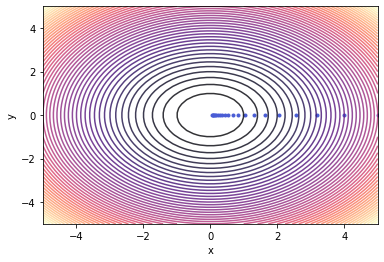

In [4]:
# Visualize iterations.
bp.visualize(iters)